In [1]:
# Import all required libraries
import cv2
from matplotlib import pyplot as plt
import numpy as np
import easyocr
import warnings
warnings.filterwarnings('ignore')

In [2]:
def BeautifyImage(img_name):
    img = cv2.imread(img_name, 1)
    # converting to LAB color space
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(12,12))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
    bilateral = cv2.bilateralFilter(enhanced_img, 15, 51, 51)
    return bilateral

In [3]:
def RecognizePlane(image_name, beautify=1, wid=1000, hei=800, scaleFactor=1.1, minNeighbors=5):
    width = wid
    height = hei
    reader = easyocr.Reader(['en'],  gpu=False, verbose=False)
    image = cv2.imread(image_name, 1)
    if(beautify):
        image=BeautifyImage(image_name)        
    # load the image, resize it, and convert it to grayscale
    image = cv2.resize(image, (width, height))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # load the number plate detector
    n_plate_detector = cv2.CascadeClassifier("haarcascade_russian_plate_number.xml")

    # detect the number plates in the grayscale image
    detections = n_plate_detector.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors)

    count=0
    totEnter=0
    # loop over the number plate bounding boxes
    for (x, y, w, h) in detections:
        # draw a rectangle around the number plate
        cv2.rectangle(image, (x, y), ((x + w)+5, (y + h)+5), (0, 255, 255), 2)
        cv2.putText(image, "Number plate detected", (x - 20, y - 10),
                    cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 255), 2)

        # extract the number plate from the grayscale image
        if (len(reader.readtext(gray[y:y + h, x:x + w], detail= 0)) == 0):
            continue
        else:
            if(count>0):
                if(len(reader.readtext(gray[y:y + h, x:x + w], detail= 0))>len(reader.readtext(number_plate, detail= 0))):
                    number_plate=gray[y-20:(y + h)+20, x-30:(x + w)+10]
                    totEnter+=1
            else:
                number_plate=gray[y-20:(y + h)+20, x-30:(x + w)+10]
                count+=1
                totEnter+=1
    if(totEnter):
        return totEnter, number_plate
    return [totEnter]

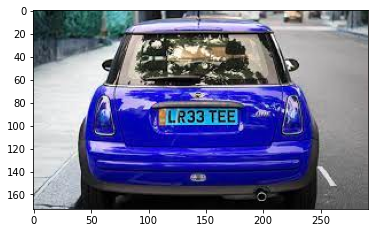

In [8]:
image_name='test.jpg' #Pass the image you want to read the plate number from
result=RecognizePlane(image_name)
totEnter=result[0]
if(totEnter>0):
    number_plate=result[1]
else:
    result=RecognizePlane(image_name,0)
    
plt.imshow(cv2.imread(image_name))

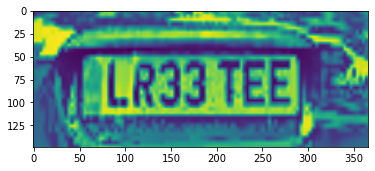

In [5]:
if(result[0]>0):
    plt.imshow(result[1])
else:
    result = RecognizePlane(image_name,0, 800, 400, 1.04, 4)
    if(result[0]>0):
        plt.imshow(result[1])        
    else:
        print('Plate number cannot be detected!')

In [6]:
reader = easyocr.Reader(['en'],  gpu=False, verbose=False)
output = reader.readtext(result[1], detail= 0)
output #It shows the extracted text from the image

['Lr33 TEE']